<div class="alert alert-block alert-info">

<b>Note:</b> this template was adpated from TeachOpenCADD's [GitHub repository](https://github.com/volkamerlab/teachopencadd).

</div>

# Understanding the Expressive Power of GNNs

**Note:** This talktorial was created as a part of the 2024-5 [Hands-on Graph Neural Networks seminar](https://cms.sic.saarland/hognn2024/) at Saarland University.

Author:
- Cameron Braunstein, 2024-5, Saarland University, https://cameronbraunstein.github.io/

## Aim of this talktorial

This tutorial is an investigation into the expressive power of graph neural networks.

Its aim is to examine how well graph neural networks can distinguish between non-isomorphic graphs. 
We will first explain the Weisfeiler-Lehman (WL) graph isomorphism test, and then construct a Graph Isomorphism Network (GIN), a graph neural network which can be formally proven to be as powerful in distinguishing graphs as the WL test.

Finally, we will provide corner-case pairs of graphs which both these methods are unable to determine whether the pair is non-isomorphic, giving participants a better sense of the limitations of these methods.

## Contents
- References
- Python Set up and Dependencies
- Motivation: Why do we want to distinguish between graphs?
- Weisfeiler-Lehman (WL) graph isomorphism test
- Graph Isomorphism Networks (GIN)
- Corner cases
- Discussion
- Quiz
- Answer Key

## References

- How Powerful are Graph Neural Networks?: [Xu et al., <i>ICLR</i> (2019)](https://arxiv.org/abs/1810.00826)

- A Short Tutorial on The Weisfeiler-Lehman Test And Its Variants: ([Huang et al. <i>ICASSP</i> (2021)](https://arxiv.org/abs/2201.07083))

## Python Set up and Dependencies

We use Python 3.11 for this notebook. To set up the talktorial venv in your terminal, navigate to the directory where the talktorial is stored. Make sure you have deactivated any conda environments if they are active. Then run:

\$ python -m venv talktorial

\$ source talktorial/bin/activate

\$ pip install jupyter ipykernel

\$ python -m ipykernel install --user --name=talktorial --display-name "Python (talktorial)"

This will create the notebook kernel. In visual studio, you can now select the correct kernel by clicking the button in the upper right, and selecting 'talktorial'. Then, run the cell below to install and all library dependencies. 

In [ ]:
requirements = """
networkx
matplotlib
"""
!pip install -r <(echo "$requirements")

import math
from enum import Enum
import networkx as nx
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Motivation: Why Do We Want to Distinguish Graphs?

Graphs are discrete data structures used to model objects (_nodes_) and their relations (_edges_ that connect nodes). Graph neural networks (_GNNs_) process graphs and produce a feature representation that can be used in downstream tasks. 

In many real world scenarios, we want GNNs to distinguish between graphs that are  _non-isomorphic_, _ie._, that have a structure.

For example, we want to check whether a given molecule is non-toxic. Assume we have a bank of known toxic molecules. The molecules are represented by graphs, where nodes are atoms, and edges are chemical bonds. If we can certify that our given molecule's structure is non-isomorphic any of the toxic molecules' structure, then we can know that the molecule is non-toxic (at least, we know it is not equivalent to any known toxic chemical).

![chemical_comparison.png](https://github.com/CameronBraunstein/talktorial/blob/master/graphics/chemical_comparison.png?raw=true)


_Caption: Non-toxic Glucose (left) and toxic Furfural (right) (Visualizations courtesy of https://pubchem.ncbi.nlm.nih.gov). We want a method for distinguishing between these molecular structures._

Determining whether two graphs are isomorphic or not is not known to be solvable in polynomial time. However, the _Weisfeiler-Lehman_ (WL) test is a useful polynomial time test used to determine whether two graphs are non-isomorphic, or undecided as isomorphic or non-isomorphic. 

In the following section, we will show how the WL test works. Later, we will construct a GNN which effectively performs the WL test.

## The Weisfeiler-Lehman Test Overview

The WL test processes graphs into directly comparable output representations. If two outputs are different, then the input graphs are formally gaurenteed to be non-isomorphic. If the outputs are the same, then the test is inconclusive: the graphs might be isomorphic, or they might be non-isomorphic.

![WL_overview.png](https://github.com/CameronBraunstein/talktorial/blob/master/graphics/WL_overview.png?raw=true)

An overview of the WL test. Two graphs are processed by the WL algorithm (to be explained below). The resulting output representations can be directly compared.

We will establish notation, present the WL algorithm, and then give an example in python code. For the remainder of this tutorial, we consider undirected graphs $G = (V,E)$, where each vertex $v \in V$ has an associated feature $x_v$. Let $N(v)$ be the set of neighboring vertices to $v$.

Let $K$ denote the number of iterations of the WL algorithm. We functions $\text{aggregate}^k$, $\text{combine}^k$ and $\text{readout}$ are injective functions which we will implement in later sections. The WL algorithm runs as follows:

$\text{WL}(G=(V,E),K)$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_v^0 \leftarrow x_v$ for $v \in V$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k \leftarrow 0$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; while $k <= K$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; for $v$ in $V$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_v^{k+1} \leftarrow \text{combine}^k(x_v^k,\text{aggregate}^k(\{ x_w^k | w \in N(v)\}))$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k \leftarrow k+1$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; return $\text{readout}(\{x_v^K | v \in V\})$


Given two graphs $G,H$, we compare $\text{WL}(G,K)$ to $\text{WL}(H,K)$. If these are different, then $G$ and $H$ are non-isomorphic. If these are the same, then the test is inconclusive. Increasing the value of $K$ will increase the discriminative power of the test, at the cost of higher computation time.

## The Weisfeiler-Lehman Test in Code

To work through the WL algorithm, we first create and visualize two graphs $G$ and $H$. In these examples, each feature $x_v$ is one of three colors: red ('r'), blue ('b'), and green ('g').

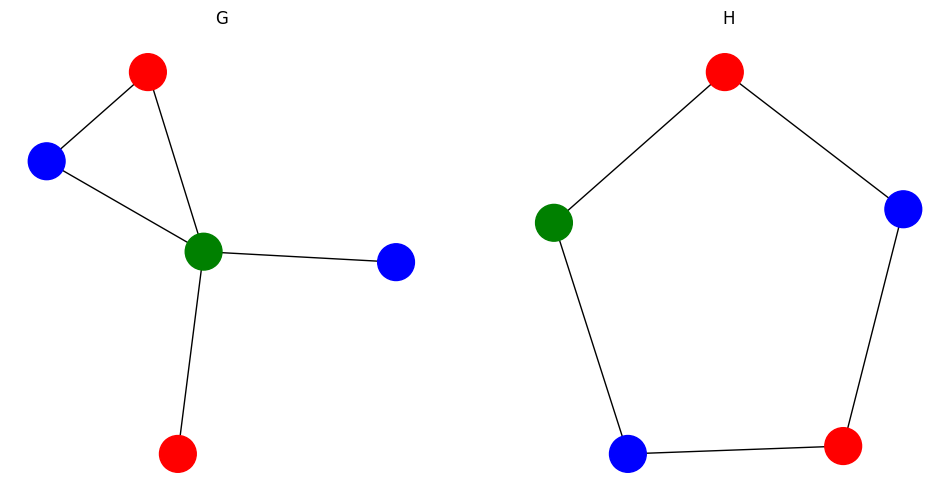

In [3]:
#Return graphs G and H that have the same number of nodes and edges, but different structure
def get_non_isomorphic_graphs():
    G = nx.Graph()
    G.add_node(0, color='r')
    G.add_node(1, color='b')
    G.add_node(2, color='g')
    G.add_node(3, color='r')
    G.add_node(4, color='b')
    G.add_edge(0, 1)
    G.add_edge(1, 2)
    G.add_edge(2, 0)
    G.add_edge(2, 3)
    G.add_edge(2, 4)

    H = nx.Graph()
    H.add_node(0, color='r')
    H.add_node(1, color='b')
    H.add_node(2, color='g')
    H.add_node(3, color='r')
    H.add_node(4, color='b')
    H.add_edge(0, 1)
    H.add_edge(1, 2)
    H.add_edge(2, 3)
    H.add_edge(3, 4)
    H.add_edge(4, 0)
    return G,H


#Enum for accessing the display arguments
class DisplayArgs(Enum):
    GRAPHS = 'graphs'
    TITLES = 'titles'
    SEEDS = 'seeds'

#Display multiple graphs in a row with supplied titles
def display_graphs(display_args):
    """
    Display multiple graphs in a row with supplied titles.

    Parameters:
    graphs (list): List of networkx graphs.
    titles (list): List of titles for the graphs.
    """
    graphs = display_args[DisplayArgs.GRAPHS]
    titles = display_args[DisplayArgs.TITLES]
    seeds = display_args[DisplayArgs.SEEDS]

    n = len(graphs)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))

    if n == 1:
        axes = [axes]

    color_dict = {
        'r': 'red',
        'g':'green',
        'b':'blue'
    }

    for i, (G, title,seed) in enumerate(zip(graphs, titles,seeds)):
        pos = nx.spring_layout(G, seed=seed)
        node_colors = [color_dict[G.nodes[node].get('color')] for node in G.nodes]
        nx.draw(G, pos, node_color=node_colors, edge_color='black', node_size=700, ax=axes[i])
        #nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes}, ax=axes[i])
        axes[i].set_title(title)

    plt.show()

G,H = get_non_isomorphic_graphs()

display_args = {
    DisplayArgs.GRAPHS: [G, H],
    DisplayArgs.TITLES: ['G', 'H'],
    DisplayArgs.SEEDS: [1, 0]
}

display_graphs(display_args)

To implement the WL test in code, we define the $\text{aggregate}^k$ and $\text{combine}^k$ functions we used in our pseudocode. The goal of these functions is to capture a unique description about the local area around the vertex. The most direct way to do this is to make each feature $x_v^k$ a traversal tree of $k$ steps, where the root is vertex $v$.

We define every $\text{aggregate}^k$ with a single function `WL_aggregate`, which collects all feature trees of neighboring nodes into a single list. We deine every $\text{combine}^k$ with a single function `WL_combine`, which forms a new tree from the aggregated feature trees, with the original vertex $v$ as the node.

We visualize how these feature trees grow for graph $G$ with respect to the max iteration count $K$. The collection of encodings after $K$ iterations is computed by `WL_encodings(G,K)`.

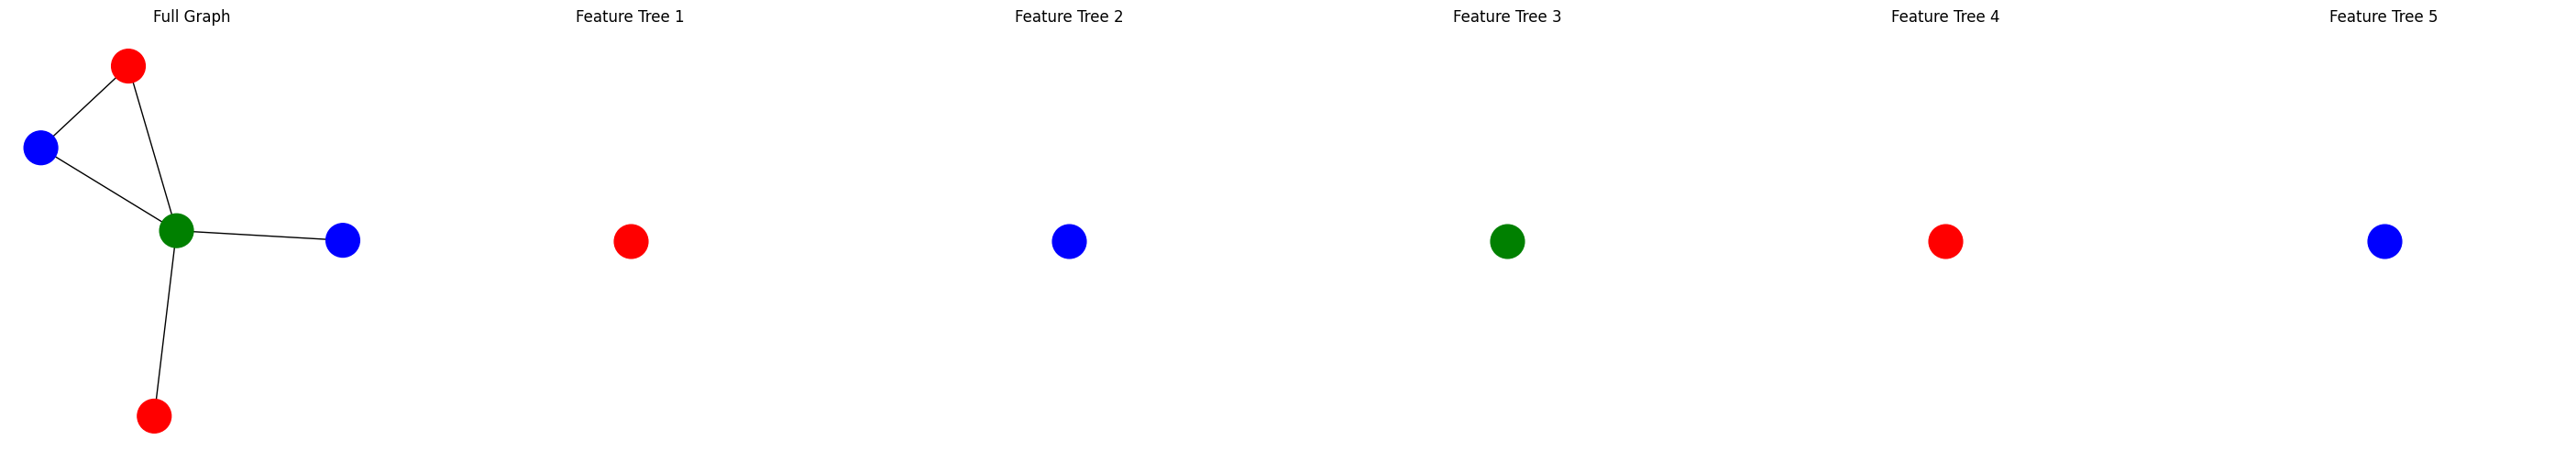

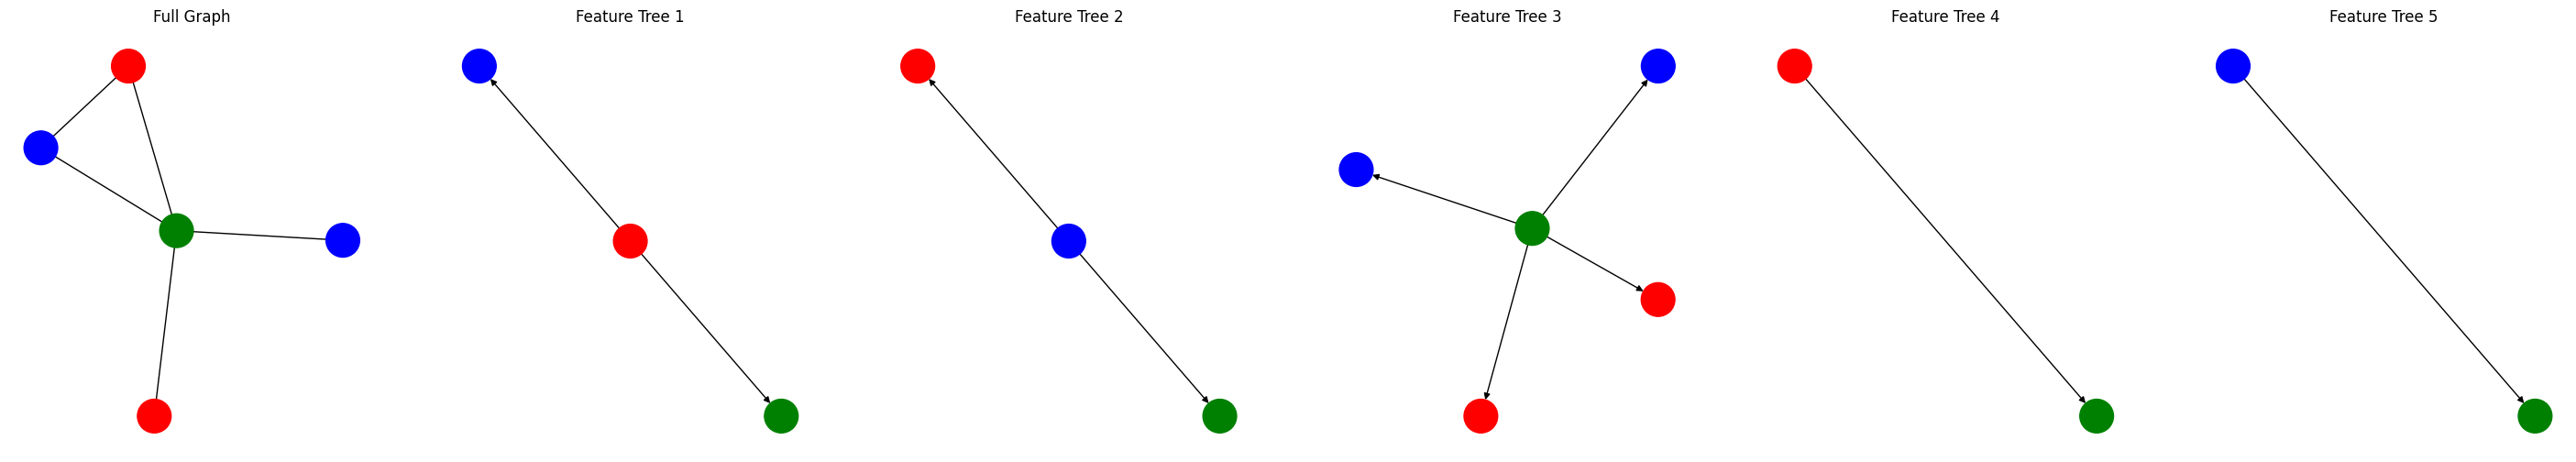

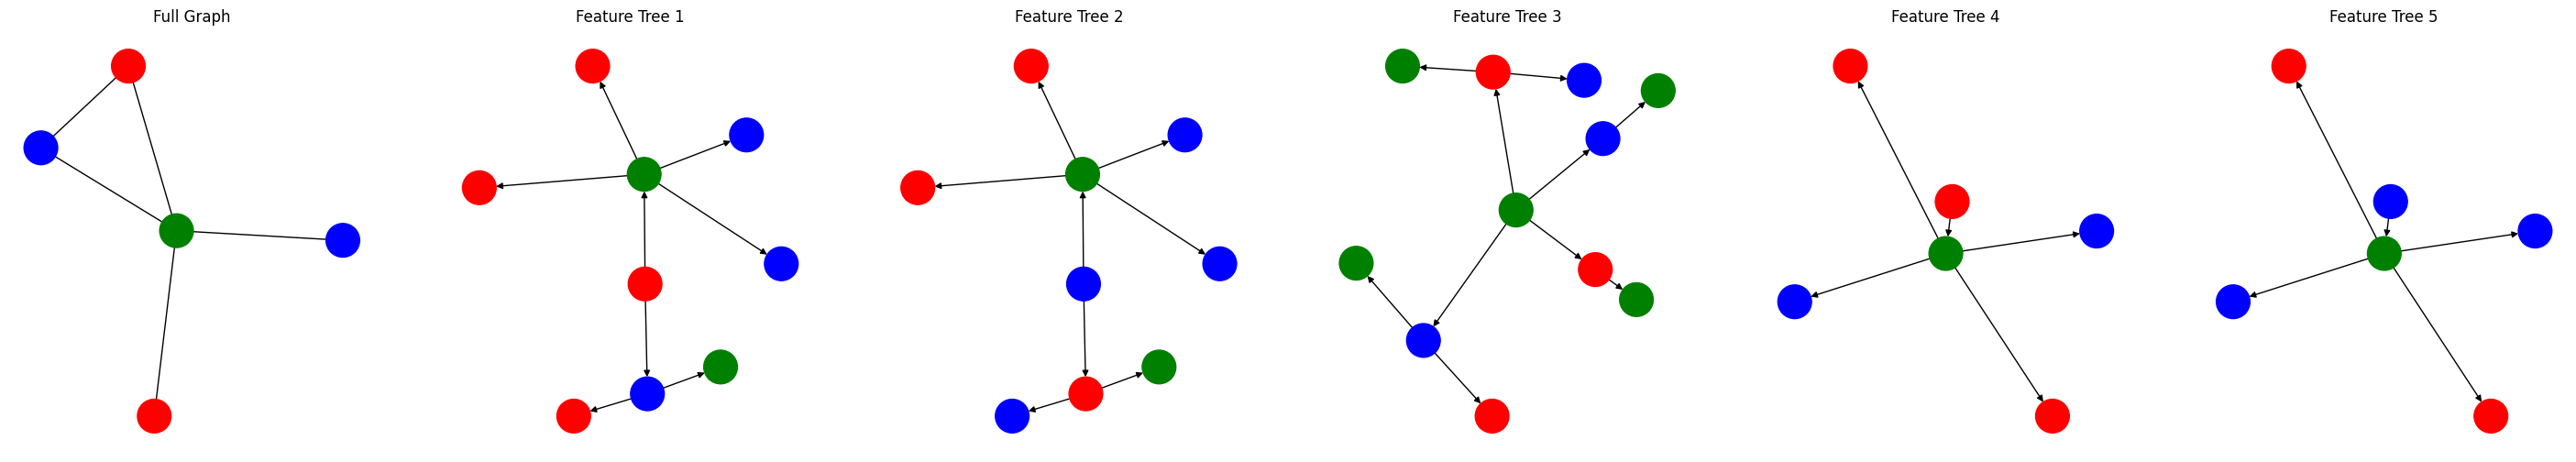

In [4]:
#Collect all neighboring feature trees
def WL_aggregate(neighbors,G_trees):
    neighbor_trees = []
    for neighbor in neighbors:
        copy_neighbor_tree = G_trees[neighbor].copy()
        neighbor_trees.append(copy_neighbor_tree)
    return neighbor_trees

#Combine the neighboring feature trees into a single tree
def WL_combine(node,aggregate_result,G):
    new_tree = nx.DiGraph()
    new_tree.add_node(node,color=G.nodes[node]['color'])
    for neighbor_tree in aggregate_result:
        mapping = {node: node + max(new_tree.nodes)+1 for node in neighbor_tree.nodes}
        mapped_neighbor_tree = nx.relabel_nodes(neighbor_tree, mapping)
        new_tree = nx.compose(new_tree, mapped_neighbor_tree)
        new_tree.add_edge(node, min(mapped_neighbor_tree.nodes))
    return new_tree

#Perform K rounds of feature tree aggregations and combinations of graph G
def WL_encodings(G,K):
    #Initialize features.
    G_trees = {}
    for node in G.nodes:
        #Node features are initially a single node tree with the original node's color
        tree_root = nx.DiGraph()
        tree_root.add_node(node,color=G.nodes[node]['color'])
        G_trees[node] = tree_root
    
    for k in range(K):
        aggregate_results = {}
        for node in G.nodes:
            #Aggregate features from neighboring nodes
            neighbors = list(G.neighbors(node))
            aggregate_results[node] = WL_aggregate(neighbors,G_trees)
        
        for node in G.nodes:
            #Combine the aggregated features with the node itself
            aggregate_result = aggregate_results[node]
            combine_result = WL_combine(node,aggregate_result,G)
            G_trees[node] = combine_result

    return G_trees


#Build displays for K= 0,1,2
G_encodings = WL_encodings(G,K=0)
display_args = {
    DisplayArgs.GRAPHS: [G,G_encodings[0], G_encodings[1],G_encodings[2],G_encodings[3],G_encodings[4]],
    DisplayArgs.TITLES: ['Full Graph','Feature Tree 1', 'Feature Tree 2','Feature Tree 3','Feature Tree 4','Feature Tree 5'],
    DisplayArgs.SEEDS: [1,1,1,1,0,0]
}
display_graphs(display_args)

G_encodings = WL_encodings(G,K=1)
display_args[DisplayArgs.GRAPHS]= [G,G_encodings[0], G_encodings[1],G_encodings[2],G_encodings[3],G_encodings[4]]
display_graphs(display_args)

G_encodings = WL_encodings(G,K=2)
display_args[DisplayArgs.GRAPHS]= [G,G_encodings[0], G_encodings[1],G_encodings[2],G_encodings[3],G_encodings[4]]

display_graphs(display_args)

We implement the $\text{readout}$ function with `WL_readout`, by converting all feature trees into alphabetically sorted strings, and then concentanting these strings together in an alphabetical order. This ordering ensures that outputs for different graphs can be accurately compared.

Our method `WL_test` runs the entire WL test. We see that the value of $K$ affects the result: higher values give monotonically more discriminative power.

In [5]:
#Combine all node feature trees into a single readout string
def WL_readout(G_encodings):

    #Helper function to represent a tree as a string
    def tree_to_string(root_node,tree):
        color = tree.nodes[root_node]['color']
        result = f'{color}'
        successor_strings = []
        for succesor in tree.successors(root_node):
            successor_strings.append(f'({tree_to_string(succesor,tree)})')
        result += ''.join(sorted(successor_strings))
        return result
    
    tree_strings = []
    for root_node, feature_tree in G_encodings.items():
        tree_strings.append(tree_to_string(root_node,feature_tree))
    return '_'.join(sorted(tree_strings))


def WL_test(G,H,K):
    #Perform K rounds of feature encodings
    G_encodings = WL_encodings(G,K)
    H_encodings = WL_encodings(H,K)

    #Combine the features together
    G_readout = WL_readout(G_encodings)
    H_readout = WL_readout(H_encodings)

    print('readout of G: ', G_readout)
    print('readout of H: ', H_readout)
    
    #Compare readouts
    if G_readout != H_readout:
        print("The graphs are not isomorphic.")
    else:
        print("WL test is inconclusive. The graphs might be isomorphic, or they might not be.")

print('After K=0 rounds of encodings, the WL-test is inconclusive:')
print()
WL_test(G,H,K=0)
print()

print('After K=1 rounds of encodings, the WL-test detects that the graphs are nonisomorphic: ')
print()
WL_test(G,H,K=1)
print()

print('After K=2 rounds of encodings, the WL-test detects that the graphs are nonisomorphic: ')
print()
WL_test(G,H,K=2)
print()

After K=0 rounds of encodings, the WL-test is inconclusive:

readout of G:  b_b_g_r_r
readout of H:  b_b_g_r_r
WL test is inconclusive. The graphs might be isomorphic, or they might not be.

After K=1 rounds of encodings, the WL-test detects that the graphs are nonisomorphic: 

readout of G:  b(g)_b(g)(r)_g(b)(b)(r)(r)_r(b)(g)_r(g)
readout of H:  b(g)(r)_b(r)(r)_g(b)(r)_r(b)(b)_r(b)(g)
The graphs are not isomorphic.

After K=2 rounds of encodings, the WL-test detects that the graphs are nonisomorphic: 

readout of G:  b(g(b)(b)(r)(r))_b(g(b)(b)(r)(r))(r(b)(g))_g(b(g)(r))(b(g))(r(b)(g))(r(g))_r(b(g)(r))(g(b)(b)(r)(r))_r(g(b)(b)(r)(r))
readout of H:  b(g(b)(r))(r(b)(b))_b(r(b)(b))(r(b)(g))_g(b(g)(r))(r(b)(g))_r(b(g)(r))(b(r)(r))_r(b(r)(r))(g(b)(r))
The graphs are not isomorphic.



## Graph Isomorphism Networks

The _Graph Isomorphism Network_ (GIN) is a constructed network which mimics the WL-algorithm, and can be formally proven to have the same discriminative power. The key idea is that each $\text{aggregate}^k$ and $\text{combine}^k$ cycle can be implemented with layer $k$ of a GNN. 

Xu _et al._ show that the vertex features $x_v^k$ can encode local area information about the vertex $v$, and can injectively encode traversal trees (meaning, two distinct traversal trees will always have distinct encodings). In code, each $x_v^k$ as an instance of the class `UniqueFloatingPointValue`:

In [7]:
#Our 1 dimenional feature vector class. It represents a real number which represents a string encoding of a feature tree.
class UniqueFloatingPointValue:
    EXP_VALUE = 1.01 #If sufficiently large integer, then the GIN is guaranteed to be injective (see Proof of Lemma 5 in appendix)
    STABILITY_MODULUS = 5000 #Added for numerical stability. Set to infinity to guarantee injectivity of the GIN
    STABILITY_DIVISION = 100 #Added for numerical stability. Set to 1 to guarantee injectivity of the GIN
    
    def __init__(self,feature_string):
        # Encode the string to bytes
        string_bytes = feature_string.encode('utf-8')
        # Convert the byte array to an integer
        self.int_feature_value = int.from_bytes(string_bytes, 'big')

    def get_as_converted_int(self):
        return self.int_feature_value

    def get_as_floating_point(self):
        reduced_integer = self.int_feature_value//UniqueFloatingPointValue.STABILITY_DIVISION
        exp_base = reduced_integer%UniqueFloatingPointValue.STABILITY_MODULUS
        denominator = (math.pow(UniqueFloatingPointValue.EXP_VALUE,exp_base))
        return 1/denominator
    
    
    def get_as_string(self):
        # Convert the integer to a byte array
        int_bytes = self.int_feature_value.to_bytes((self.int_feature_value.bit_length() + 7) // 8, 'big')
        # Decode the byte array to a string
        feature_string = int_bytes.decode('utf-8')
        return feature_string

We now adapt the WL test functions to a GIN. Each method with the name `WL_<action>` is renamed to `GIN_<action>`, and the code is tweaked to handle the new feature format. 

Each each $\text{aggregate}^k$ and $\text{combine}^k$ cycle is implementented through `GIN_aggregate` and `GIN_combine`, which accumulate the vertices' local area information in a collision-free manner.

An effective implementation of `GIN_aggregate` and `GIN_combine` can also be repurposed for the WL algorithm. Therefore, the GIN is _at most_ as powerful as the WL test in distinguishing graphs.

Just as in `WL_test`, `GIN_test` is inconclusive when $K=0$, but conclusive when $K>=1$

In [10]:
#Collect the set of all neighboring features
def GIN_aggregate(neighbors,G_features):
    neighbor_trees = []
    for neighbor in neighbors:
        neighbor_trees.append(G_features[neighbor])
    return neighbor_trees

# Combine all features. In a true GIN, this is implemented by summing the local features 
# together, and then passing this feature through an MLP.
#
# For clarity, we perform these steps together through alphabetized string concatenation, 
# similar to the WL-test code.
#
# Xu et al. show that a sufficiently large MLP will be able to perform a computation that is 
# practically equivalent to this alphabetized string concatenation, losslessly encoding all
# local area information.
def GIN_combine(node,aggregate_result,G_features):
    root_feature = G_features[node]
    combination_string = root_feature.get_as_string()
    results_strings = []
    for result in aggregate_result:
        results_strings.append(result.get_as_string())
    
    for result_string in sorted(results_strings):
        combination_string+=f'({result_string})'

    combination_floating_point_value = UniqueFloatingPointValue(combination_string)
    return combination_floating_point_value

def GIN_encodings(G,K):
    #Initialize features.
    G_features = {}
    for node in G.nodes:
        #Node features are initially the node's color
        G_features[node] = UniqueFloatingPointValue(G.nodes[node]['color'])
    
    for k in range(K):
        aggregate_results = {}
        for node in G.nodes:
            #Aggregate features from neighboring nodes
            neighbors = list(G.neighbors(node))
            aggregate_results[node] = GIN_aggregate(neighbors,G_features)
        
        for node in G.nodes:
            #Combine the aggregated features with the node itself
            aggregate_result = aggregate_results[node]
            combine_result = GIN_combine(node,aggregate_result,G_features)
            G_features[node] = combine_result

    return G_features

#Combine all node feature trees into a single readout string
def GIN_readout(G_encodings):
    feature_strings = []
    for encoding in G_encodings.values():
        feature_strings.append(encoding.get_as_string())

    combined_feature =  UniqueFloatingPointValue('_'.join(sorted(feature_strings)))
    return combined_feature


def GIN_test(G,H,K):
    #Perform K rounds of feature encodings
    G_encodings = GIN_encodings(G,K)
    H_encodings = GIN_encodings(H,K)

    #Combine the features together
    G_readout = GIN_readout(G_encodings)
    H_readout = GIN_readout(H_encodings)

    print('readout of G (string): ', G_readout.get_as_string())
    print('readout of H (string): ', H_readout.get_as_string())

    int_G_readout = G_readout.get_as_floating_point()
    int_H_readout = H_readout.get_as_floating_point()
    

    print('readout of G (floating point): ', int_G_readout)
    print('readout of H (floating point): ', int_H_readout)
    #Compare readouts
    if int_G_readout != int_H_readout:
        print("The graphs are not isomorphic.")
    else:
        print("Comparing GIN encodings is inconclusive. The graphs might be isomorphic, or they might not be.")

print('After K=0 rounds of encodings, the GIN is inconclusive:')
print()
GIN_test(G,H,K=0)
print()

print('After K=1 rounds of encodings, the GIN detects that the graphs are nonisomorphic: ')
print()
GIN_test(G,H,K=1)
print()

print('After K=1 rounds of encodings, the GIN detects that the graphs are nonisomorphic: ')
print()
GIN_test(G,H,K=2)
print()



After K=0 rounds of encodings, the GIN is inconclusive:

readout of G (string):  b_b_g_r_r
readout of H (string):  b_b_g_r_r
readout of G (floating point):  1.6472170277642556e-20
readout of H (floating point):  1.6472170277642556e-20
Comparing GIN encodings is inconclusive. The graphs might be isomorphic, or they might not be.

After K=1 rounds of encodings, the GIN detects that the graphs are nonisomorphic: 

readout of G (string):  b(g)_b(g)(r)_g(b)(b)(r)(r)_r(b)(g)_r(g)
readout of H (string):  b(g)(r)_b(r)(r)_g(b)(r)_r(b)(b)_r(b)(g)
readout of G (floating point):  0.0004052486536043118
readout of H (floating point):  5.1496251644495353e-14
The graphs are not isomorphic.

After K=1 rounds of encodings, the GIN detects that the graphs are nonisomorphic: 

readout of G (string):  b(g)(g(b)(b)(r)(r))_b(g)(r)(g(b)(b)(r)(r))(r(b)(g))_g(b)(b)(r)(r)(b(g))(b(g)(r))(r(b)(g))(r(g))_r(b)(g)(b(g)(r))(g(b)(b)(r)(r))_r(g)(g(b)(b)(r)(r))
readout of H (string):  b(g)(r)(g(b)(r))(r(b)(b))_b(r)(r)(r(

## Corner Cases
Even some simple pairs of graphs are indistinguishable for the WL test, and thus, also by the GIN.

We show a case below:

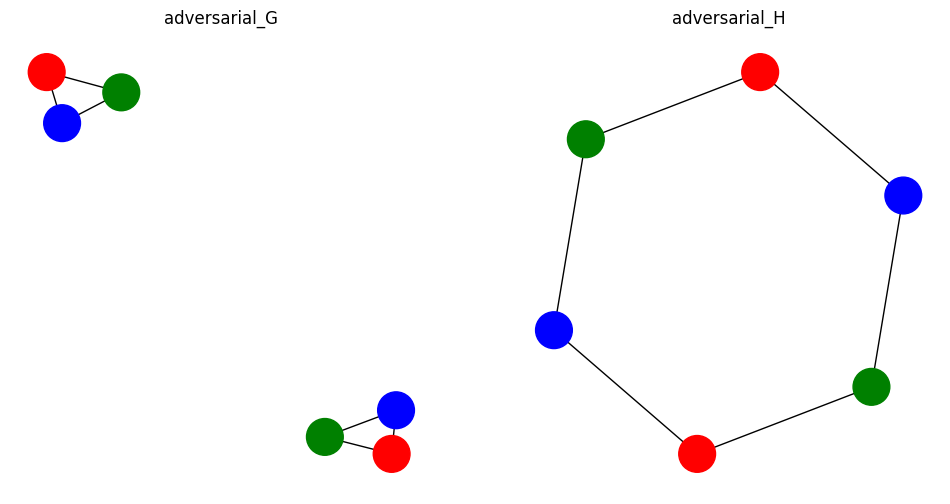

In [11]:
def get_adversarial_non_isomorphic_graphs():
    adversarial_G = nx.Graph()
    adversarial_G.add_node(0, color='r')
    adversarial_G.add_node(1, color='b')
    adversarial_G.add_node(2, color='g')
    adversarial_G.add_node(3, color='r')
    adversarial_G.add_node(4, color='b')
    adversarial_G.add_node(5, color='g')
    adversarial_G.add_edge(0, 1)
    adversarial_G.add_edge(1, 2)
    adversarial_G.add_edge(2, 0)
    adversarial_G.add_edge(3, 4)
    adversarial_G.add_edge(4, 5)
    adversarial_G.add_edge(5,3)

    adversarial_H = nx.Graph()
    adversarial_H.add_node(0, color='r')
    adversarial_H.add_node(1, color='b')
    adversarial_H.add_node(2, color='g')
    adversarial_H.add_node(3, color='r')
    adversarial_H.add_node(4, color='b')
    adversarial_H.add_node(5, color='g')
    adversarial_H.add_edge(0, 1)
    adversarial_H.add_edge(1, 2)
    adversarial_H.add_edge(2, 3)
    adversarial_H.add_edge(3, 4)
    adversarial_H.add_edge(4, 5)
    adversarial_H.add_edge(5,0)
    return adversarial_G,adversarial_H


adversarial_G,adversarial_H = get_adversarial_non_isomorphic_graphs()

display_args = {
    DisplayArgs.GRAPHS: [adversarial_G,adversarial_H],
    DisplayArgs.TITLES: ['adversarial_G','adversarial_H'],
    DisplayArgs.SEEDS: [2, 0]
}

display_graphs(display_args)

Although these graphs are obviously non-isomorphic, the WL algorithm will not create different representations for any value of $K$

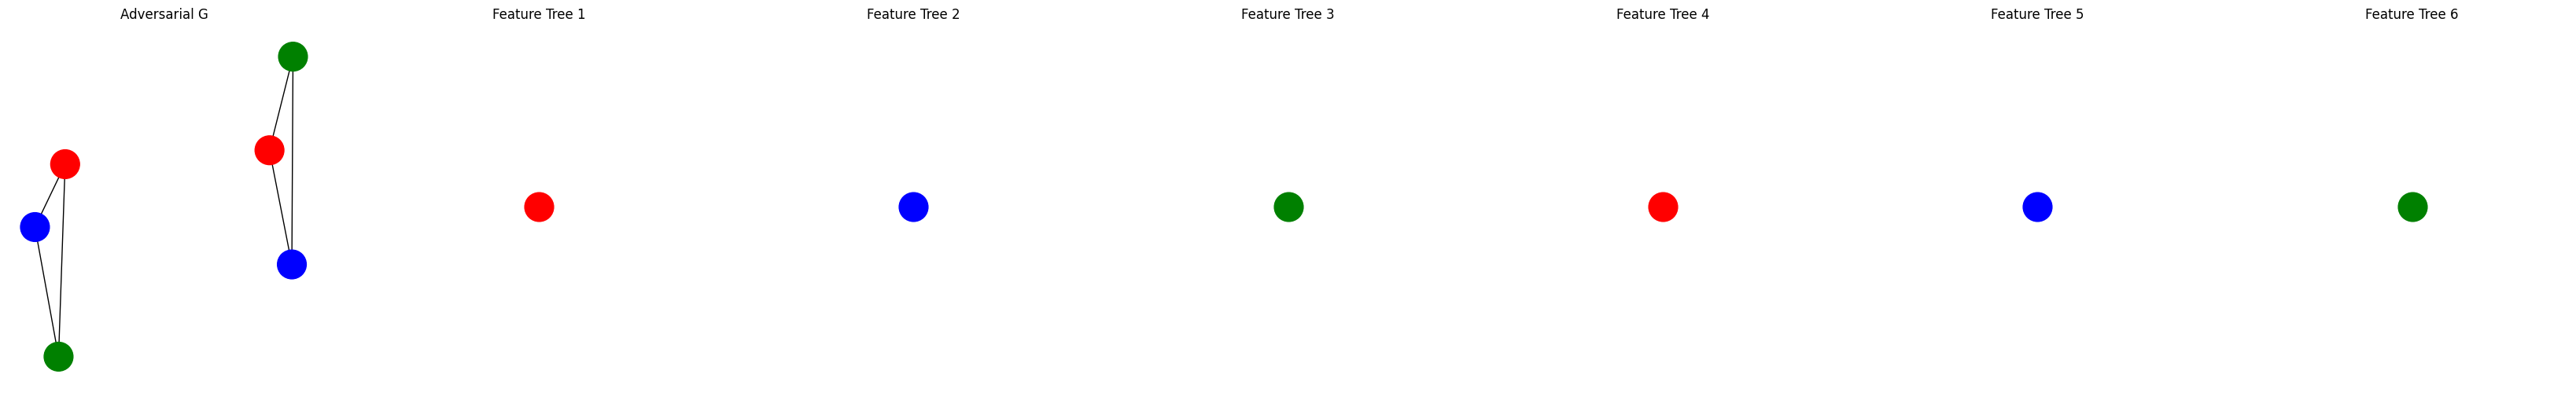

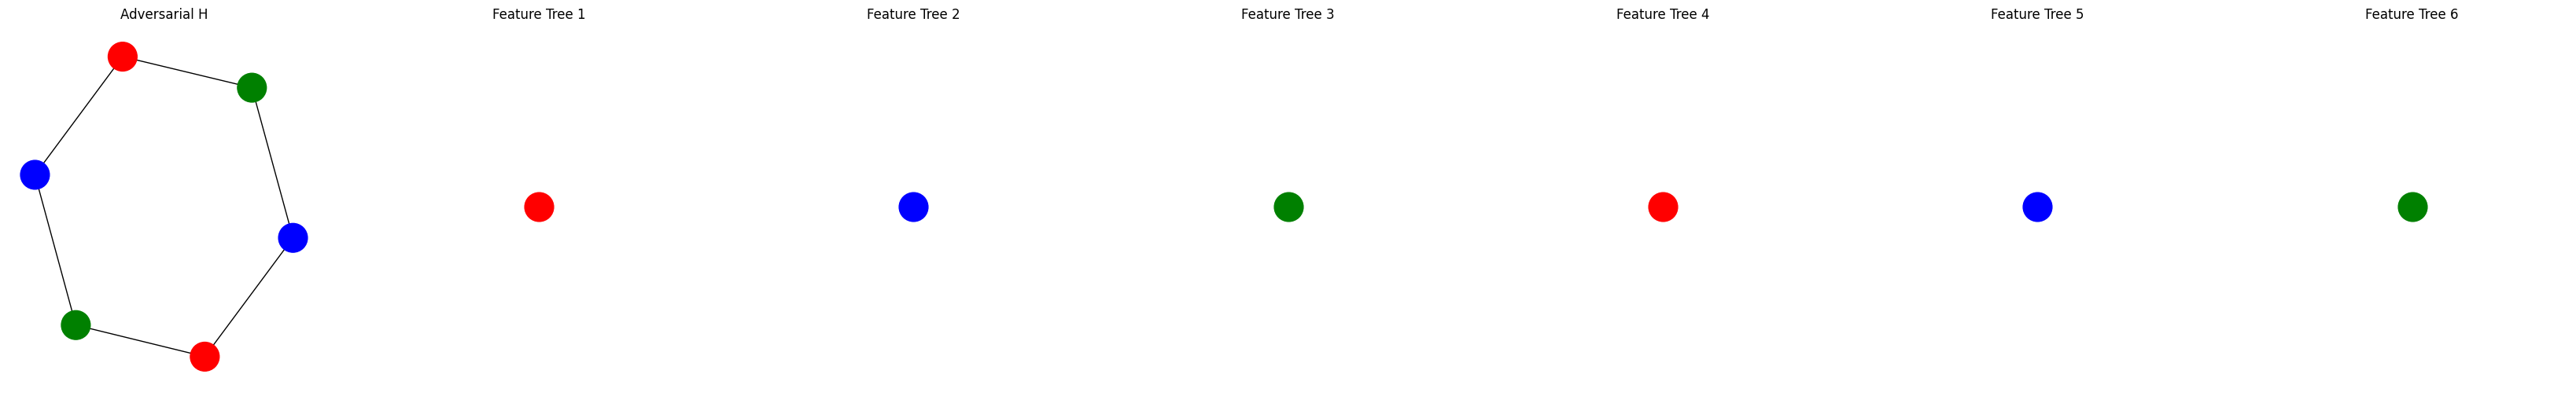

In [12]:
#Build displays for adversial G for  K=0
G_encodings = WL_encodings(adversarial_G,K=0)
display_args = {
    DisplayArgs.GRAPHS: [adversarial_G,G_encodings[0], G_encodings[1],G_encodings[2],G_encodings[3],G_encodings[4],G_encodings[5]],
    DisplayArgs.TITLES: ['Adversarial G','Feature Tree 1', 'Feature Tree 2','Feature Tree 3','Feature Tree 4','Feature Tree 5','Feature Tree 6'],
    DisplayArgs.SEEDS: [1,1,1,1,0,0,0]
}
display_graphs(display_args)

#Build displays for adversial H for  K=0
H_encodings = WL_encodings(adversarial_H,K=0)
display_args = {
    DisplayArgs.GRAPHS: [adversarial_H,H_encodings[0], H_encodings[1],H_encodings[2],H_encodings[3],H_encodings[4],H_encodings[5]],
    DisplayArgs.TITLES: ['Adversarial H','Feature Tree 1', 'Feature Tree 2','Feature Tree 3','Feature Tree 4','Feature Tree 5','Feature Tree 6'],
    DisplayArgs.SEEDS: [1,1,1,1,0,0,0]
}
display_graphs(display_args)


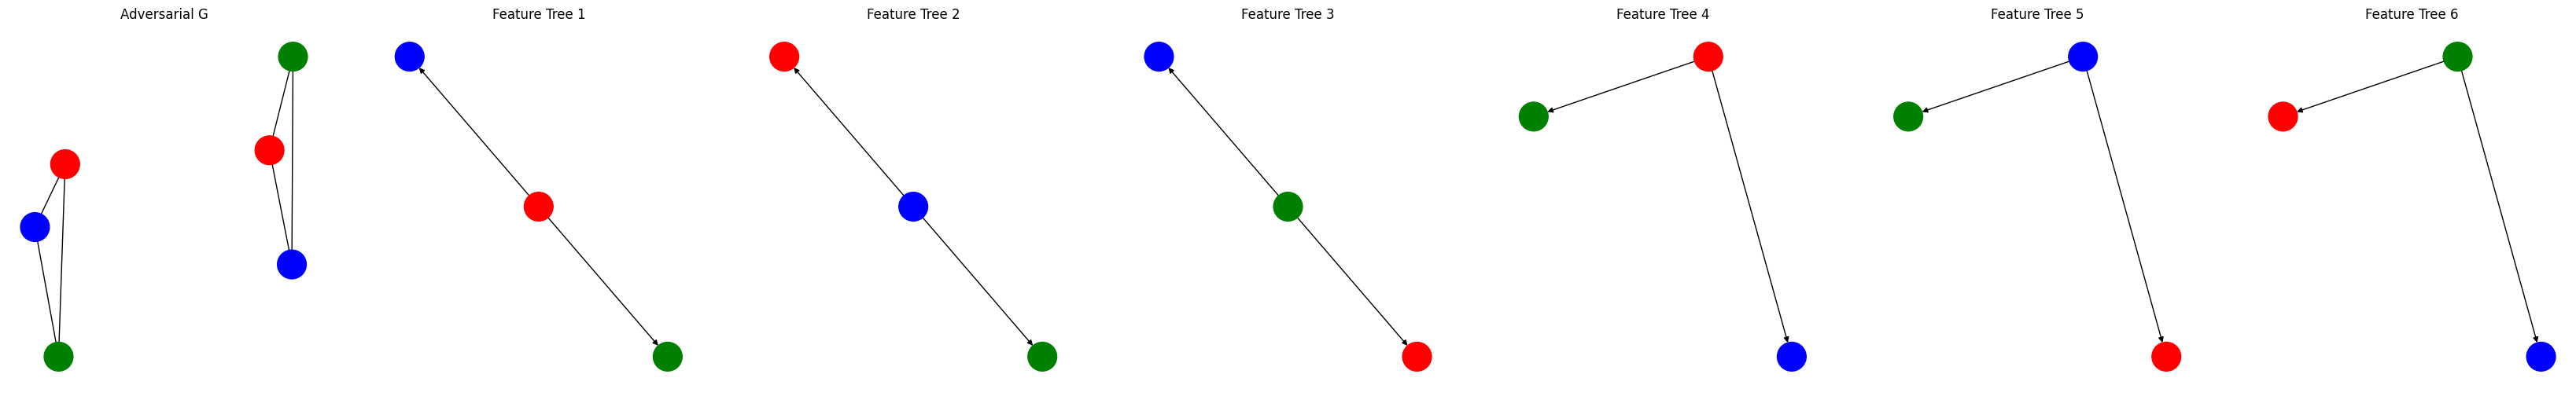

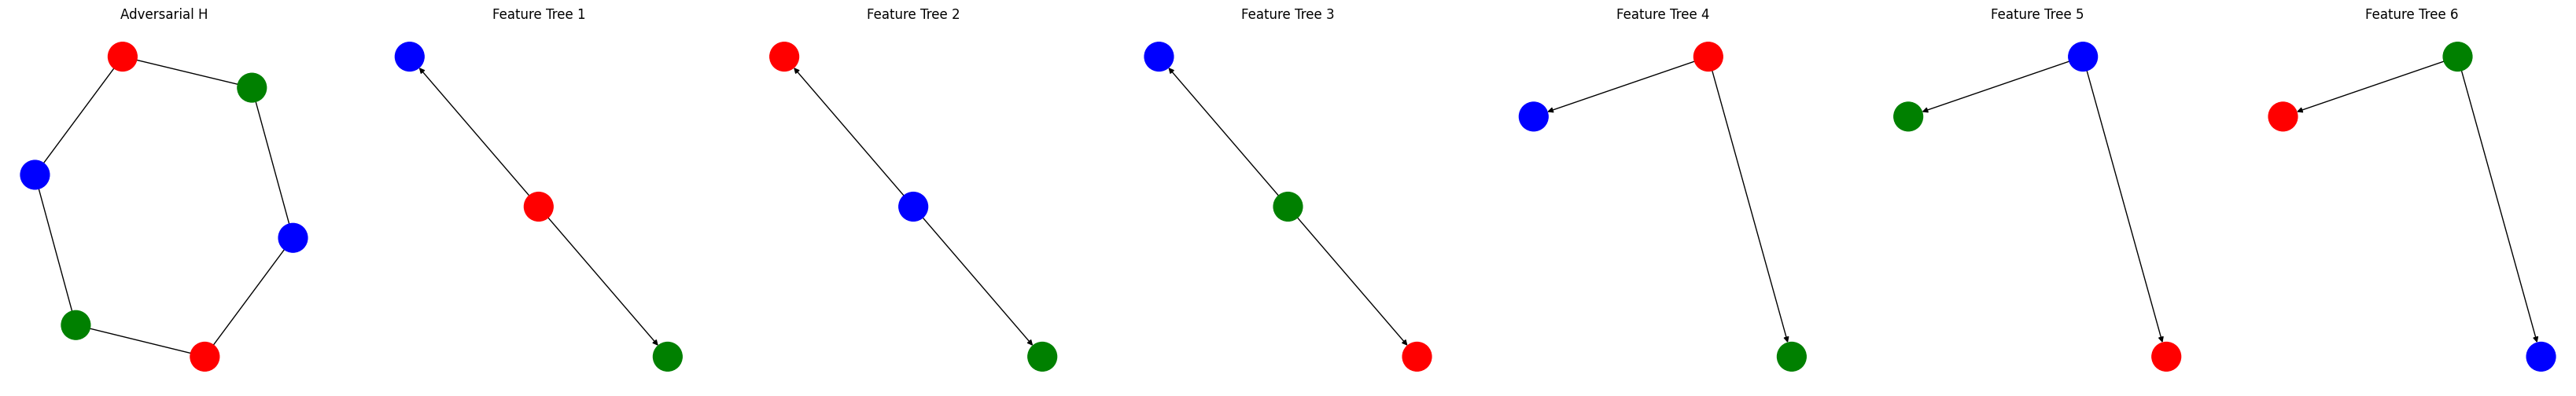

In [13]:
#Build displays for adversial G for  K=1
G_encodings = WL_encodings(adversarial_G,K=1)
display_args = {
    DisplayArgs.GRAPHS: [adversarial_G,G_encodings[0], G_encodings[1],G_encodings[2],G_encodings[3],G_encodings[4],G_encodings[5]],
    DisplayArgs.TITLES: ['Adversarial G','Feature Tree 1', 'Feature Tree 2','Feature Tree 3','Feature Tree 4','Feature Tree 5','Feature Tree 6'],
    DisplayArgs.SEEDS: [1,1,1,1,0,0,0]
}
display_graphs(display_args)

#Build displays for adversial H for  K=1
H_encodings = WL_encodings(adversarial_H,K=1)
display_args = {
    DisplayArgs.GRAPHS: [adversarial_H,H_encodings[0], H_encodings[1],H_encodings[2],H_encodings[3],H_encodings[4],H_encodings[5]],
    DisplayArgs.TITLES: ['Adversarial H','Feature Tree 1', 'Feature Tree 2','Feature Tree 3','Feature Tree 4','Feature Tree 5','Feature Tree 6'],
    DisplayArgs.SEEDS: [1,1,1,1,0,0,0]
}
display_graphs(display_args)

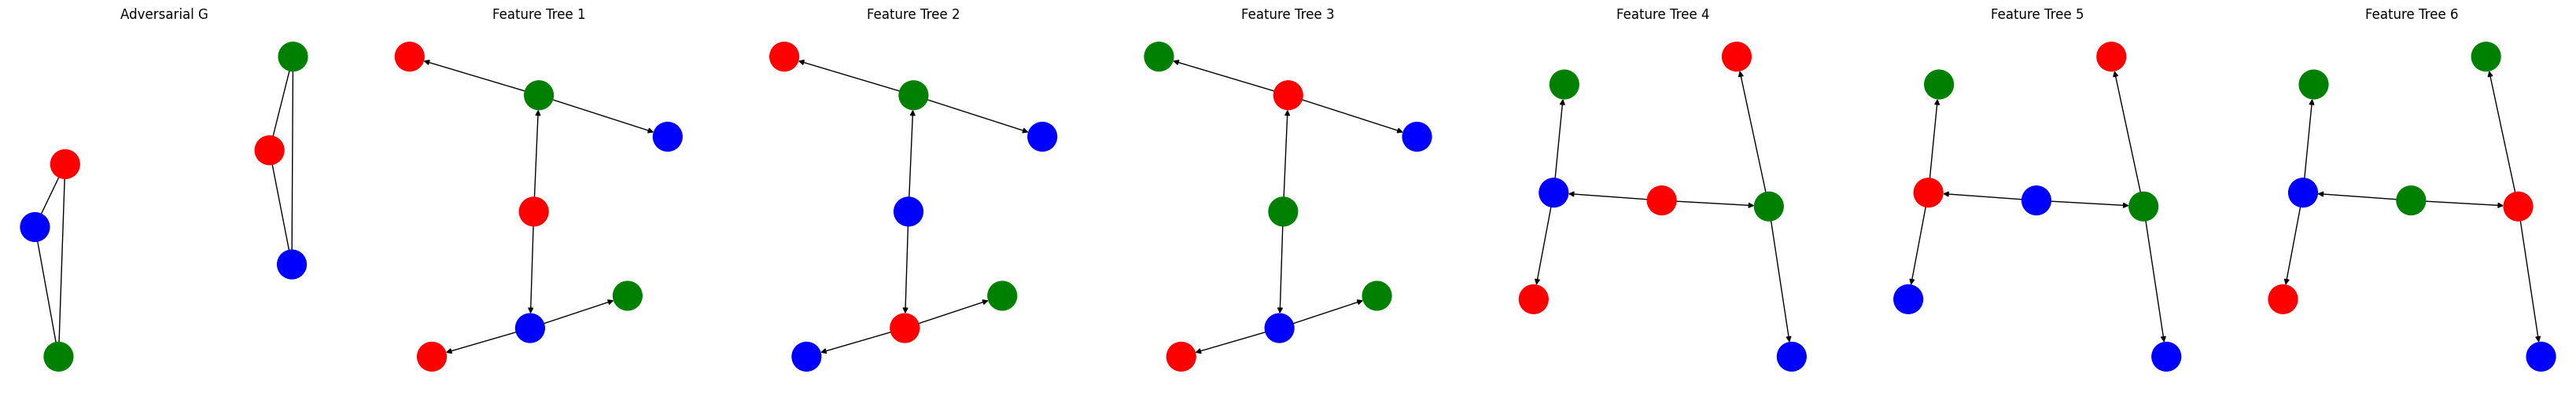

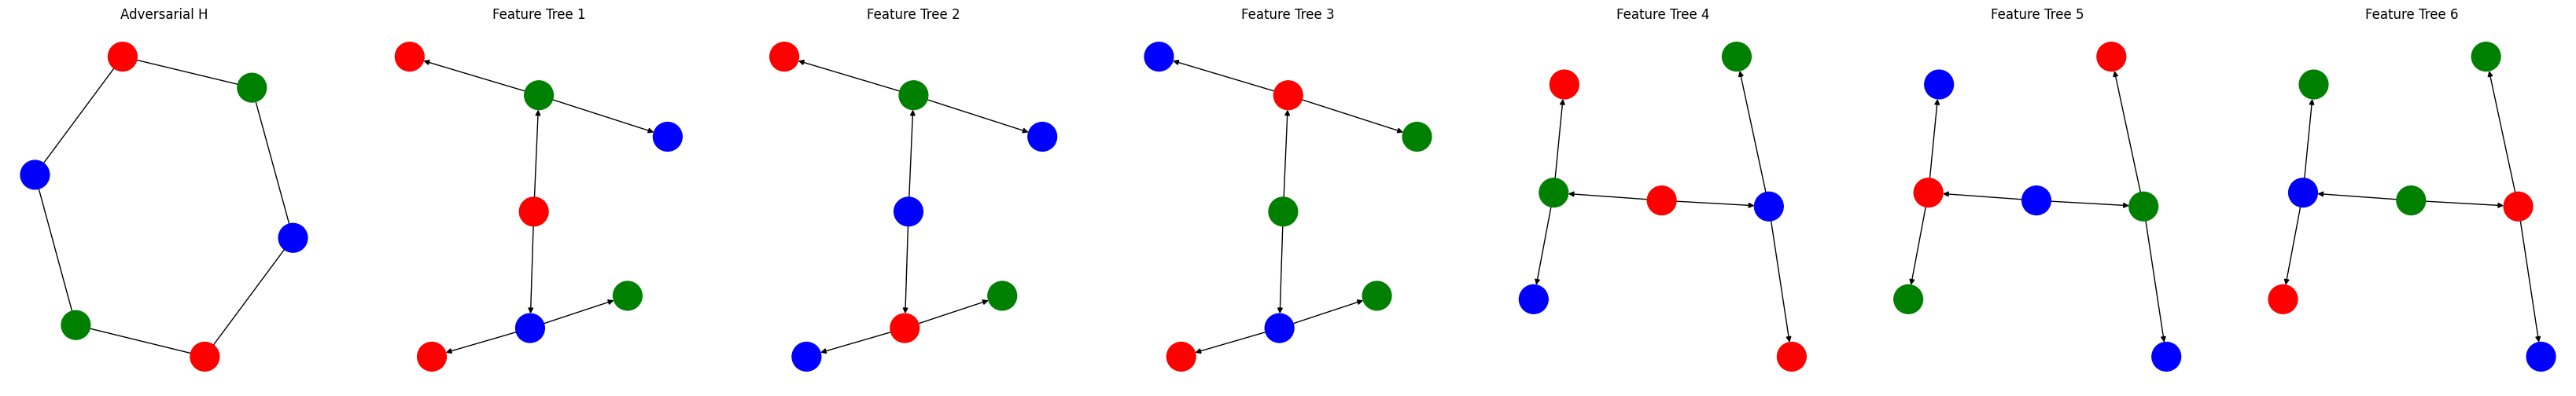

In [14]:
#Build displays for adversial G for  K=2
G_encodings = WL_encodings(adversarial_G,K=2)
display_args = {
    DisplayArgs.GRAPHS: [adversarial_G,G_encodings[0], G_encodings[1],G_encodings[2],G_encodings[3],G_encodings[4],G_encodings[5]],
    DisplayArgs.TITLES: ['Adversarial G','Feature Tree 1', 'Feature Tree 2','Feature Tree 3','Feature Tree 4','Feature Tree 5','Feature Tree 6'],
    DisplayArgs.SEEDS: [1,1,1,1,0,0,0]
}
display_graphs(display_args)

#Build displays for adversial H for  K=2
H_encodings = WL_encodings(adversarial_H,K=2)
display_args = {
    DisplayArgs.GRAPHS: [adversarial_H,H_encodings[0], H_encodings[1],H_encodings[2],H_encodings[3],H_encodings[4],H_encodings[5]],
    DisplayArgs.TITLES: ['Adversarial H','Feature Tree 1', 'Feature Tree 2','Feature Tree 3','Feature Tree 4','Feature Tree 5','Feature Tree 6'],
    DisplayArgs.SEEDS: [1,1,1,1,0,0,0]
}
display_graphs(display_args)

Thus, both `WL_test` and `GIN_test` are inconclusive.

In [15]:
print()
WL_test(adversarial_G,adversarial_H,K=0)
print()

print()
WL_test(adversarial_G,adversarial_H,K=1)
print()

print()
WL_test(adversarial_G,adversarial_H,K=2)
print()


readout of G:  b_b_g_g_r_r
readout of H:  b_b_g_g_r_r
WL test is inconclusive. The graphs might be isomorphic, or they might not be.


readout of G:  b(g)(r)_b(g)(r)_g(b)(r)_g(b)(r)_r(b)(g)_r(b)(g)
readout of H:  b(g)(r)_b(g)(r)_g(b)(r)_g(b)(r)_r(b)(g)_r(b)(g)
WL test is inconclusive. The graphs might be isomorphic, or they might not be.


readout of G:  b(g(b)(r))(r(b)(g))_b(g(b)(r))(r(b)(g))_g(b(g)(r))(r(b)(g))_g(b(g)(r))(r(b)(g))_r(b(g)(r))(g(b)(r))_r(b(g)(r))(g(b)(r))
readout of H:  b(g(b)(r))(r(b)(g))_b(g(b)(r))(r(b)(g))_g(b(g)(r))(r(b)(g))_g(b(g)(r))(r(b)(g))_r(b(g)(r))(g(b)(r))_r(b(g)(r))(g(b)(r))
WL test is inconclusive. The graphs might be isomorphic, or they might not be.



In [16]:
print()
GIN_test(adversarial_G,adversarial_H,K=0)
print()

print()
GIN_test(adversarial_G,adversarial_H,K=1)
print()

print()
GIN_test(adversarial_G,adversarial_H,K=2)
print()


readout of G (string):  b_b_g_g_r_r
readout of H (string):  b_b_g_g_r_r
readout of G (floating point):  0.17704389754098593
readout of H (floating point):  0.17704389754098593
Comparing GIN encodings is inconclusive. The graphs might be isomorphic, or they might not be.


readout of G (string):  b(g)(r)_b(g)(r)_g(b)(r)_g(b)(r)_r(b)(g)_r(b)(g)
readout of H (string):  b(g)(r)_b(g)(r)_g(b)(r)_g(b)(r)_r(b)(g)_r(b)(g)
readout of G (floating point):  5.800448434217529e-09
readout of H (floating point):  5.800448434217529e-09
Comparing GIN encodings is inconclusive. The graphs might be isomorphic, or they might not be.


readout of G (string):  b(g)(r)(g(b)(r))(r(b)(g))_b(g)(r)(g(b)(r))(r(b)(g))_g(b)(r)(b(g)(r))(r(b)(g))_g(b)(r)(b(g)(r))(r(b)(g))_r(b)(g)(b(g)(r))(g(b)(r))_r(b)(g)(b(g)(r))(g(b)(r))
readout of H (string):  b(g)(r)(g(b)(r))(r(b)(g))_b(g)(r)(g(b)(r))(r(b)(g))_g(b)(r)(b(g)(r))(r(b)(g))_g(b)(r)(b(g)(r))(r(b)(g))_r(b)(g)(b(g)(r))(g(b)(r))_r(b)(g)(b(g)(r))(g(b)(r))
readout of G (flo

## Discussion

In this talktorial, we have introduced the graph isomorphism problem. We have explained a powerful heuristic for distinguishing graphs, the Weisfeiler-Lehman (WL) graph isomorphism test. The test works by gathering local area information for each vertex (a traversal tree in the most straightfoward case), and combines them into a final readout such that we can confidently distinguish between many pairs of non-isomorphic graphs.

We can constructed a Graph Isomorphism Network (GIN), which mimics the WL test. Here, each vertices' traversal tree information is encoded into a 1 dimensional floating point value, which is processed through the network. Given a sufficiently underlying MLP for the GIN, we can gaurentee that this process is just as powerful as the WL test in discriminative power.

Finally, we showed corner cases which fool both methods. This demonstrates that even the most sophisticated GNNs are limited in fully understanding graph structure.

There is more to the story: _Xu et al._ show that the architecture of several popular GNNs (notably, _Graph Convolutional Networks_ (GCNs) and _GraphSAGE_) are non-injective, making them theoretically incapable of being GINs. Additionally, they show that, with the proper archtecture, it is possible to train a very effective GNN for distinguishing between graphs using alternative training objectives with stochastic gradient descent. While these practical implementations are not injective in 100\% of cases, and thus, not true GINs, they are still useful.

There are more advanced versions of the WL-test with more discriminative power. It is up to future work to design a GNN architecture which can mimic these more advanced WL-test variants.

## Quiz:

1) True or False: there exist some graph pairs which a K-layer GIN can distinguish between, but the WL test with K iterations cannot.

2) True or False: True or False: there exist some graph pairs which a K-layer GIN can distinguish between, but the WL test with _K-1_ iterations cannot.

3) True or False: with a sufficiently large number of iterations $K$, the WL test (and thus, the GIN) can distinguish between every pair of non-isomorphic graphs.

4) When distinguishing graphs, why do the `aggregate`, `combine`, and `readout` functions have to be injective on the sets of vertex features, both in the case of the WL test and the GIN?/What could go wrong if these functions were not injective?

5) True or False: if `GIN_aggregate`, `GIN_combine`, and `GIN_readout` are all proven to be injective, then a K-layer GIN is as powerful as the WL test with $K$ iterations.

## Answer Key

1. False (the GIN is _at most_ as poweful as the WL test)

2. True (see our first example)

3. False (see our counter example)

4. A non-injective function could confuse local area information (imagine that it produces the same tree for different neighborhoods). Then, the test might be inconclusive, when it should show that the graphs are non-isomorphic.

5. True (Under these conditions, the GIN is essentially the WL test)